In [ ]:

import warnings
warnings.filterwarnings('ignore')
#importing numpy library
import numpy as np
#importing pandas library
import pandas as pd
#importing seaborn library
import seaborn as sns
#imorting matplotlib library
import matplotlib.pyplot as plt
#Importing Library for train test split
from sklearn.model_selection import train_test_split
from string import punctuation
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Multiply,Flatten
from tensorflow.keras.layers import LSTM

import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading csv file of Question Pair Dataset Available publically
Quora_questions = pd.read_csv("//content//drive//MyDrive//questions.csv")
print("Number of data points:",Quora_questions.shape[0])

Number of data points: 404351


In [ ]:
#Splitting the dataset 
train,test = train_test_split(Quora_questions, test_size=0.33, random_state=42)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
181139,181139,357761,357762,What is the most interesting Road Trip Story y...,What are the best road trip songs?,0
284223,284223,558625,558626,How do I install a custom Rom in Spice mettle ...,How do I install a custom ROM in my rooted phone?,0
314840,314840,617874,617875,Has sugar hill gang's rapper's delight ever be...,"What is the translation of the word ""by"" to Fr...",0
337099,337099,660891,660892,How do I study math?,How should I study math?,1
84444,84444,167712,167713,Which mobile development companies are based i...,Top mobile app companies in Miami Florida?,1


In [ ]:
#Getting to  know the information regarding the dataset
Quora_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


array([0, 0, 0, ..., 0, 0, 0])

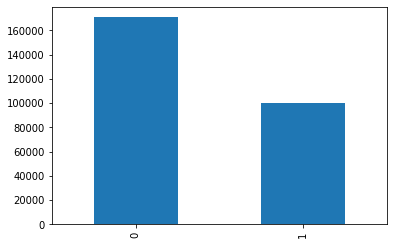

In [ ]:
#check the total questions that are duplicate as per is_dupliacte column and other way round. For TRAINING SET
train['is_duplicate'].value_counts().plot.bar()
train['is_duplicate'].values



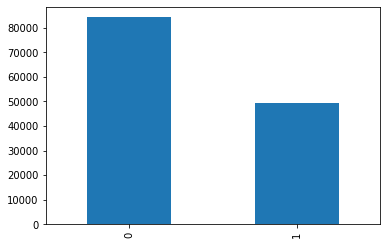

In [ ]:
#check the total questions that are duplicate as per is_dupliacte column and other way round. For TESTING SET
test['is_duplicate'].value_counts().plot.bar()


In [ ]:
#Dropping all the na values present in the training and testing set if any
train.isna().values.any()
train.dropna(inplace=True,axis=0)

test.isna().values.any()
test.dropna(inplace=True,axis=0)
print(len(train))


270912


In [ ]:
'''converting the train and testing question pairs to list of questions that will be passed on to the lstm models after data cleaning,
preprocessing, and embedding it with different embedding models'''

train_q1=pd.Series(train.question1.tolist())
train_q2=pd.Series(train.question2.tolist())
test_q1=pd.Series(test.question1.tolist())
test_q2=pd.Series(test.question2.tolist())
train_q1[:5]
print(len(train_q1))

270912


In [ ]:
def cleaning_text(q):
    cleaned_text=[]
    for text in q:
        text = text.lower()

        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)

        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        cleaned_text.append(words)
    return cleaned_text


In [ ]:

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()

def lemma(q1):
    Lemmatized=[]
    for sentences in q1:
        tokens = word_tokenize(sentences)
#         print(tokens)
        # Lemmatization of words
        
        
        lemmatized_output = ' '.join([wordnet.lemmatize(w,pos="v") for w in tokens])
        Lemmatized.append(lemmatized_output)
    return Lemmatized

In [ ]:
#storing the cleaned data
cleaned_train_q1=cleaning_text(train_q1)
cleaned_train_q2=cleaning_text(train_q2)
cleaned_test_q1=cleaning_text(test_q1)
cleaned_test_q2=cleaning_text(test_q2)

In [ ]:
#storing the lemmatized question pairs:
final_train_q1=lemma(cleaned_train_q1)
final_train_q2=lemma(cleaned_train_q2)
final_test_q1=lemma(cleaned_test_q1)
final_test_q2=lemma(cleaned_test_q2)

In [ ]:
train_labels=train['is_duplicate'].values
print(len(train_labels))
test_labels=test['is_duplicate'].values
print(len(test_labels))

270912
133436


In [ ]:
print(len(final_train_q1),len(train_labels))

270912 270912


In [ ]:
max_seq_length=0
for i in final_train_q1:
  max_seq_length=len(i.split(' ')) if len(i.split(' '))>max_seq_length else max_seq_length
print(max_seq_length)

53


In [ ]:
max_seq_length = max(train.question1.map(lambda x: len(x)).max(),
                     train.question2.map(lambda x: len(x)).max(),
                     test.question1.map(lambda x: len(x)).max(),
                     test.question2.map(lambda x: len(x)).max())
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(final_train_q1+final_train_q2)

tr_q1 = tokenizer.texts_to_sequences(final_train_q1)
tr_q1 = pad_sequences(tr_q1, maxlen =54, padding='post')

# tokenizer.fit_on_texts(final_train_q2)
tr_q2 = tokenizer.texts_to_sequences(final_train_q2)
tr_q2 = pad_sequences(tr_q2, maxlen = 54, padding='post')

tokenizer1 = Tokenizer(num_words=200000)
tokenizer1.fit_on_texts(final_test_q1+final_test_q2)

test_q1 = tokenizer.texts_to_sequences(final_test_q1)
test_q1 = pad_sequences(test_q1, maxlen = 54, padding='post')

test_q2 = tokenizer.texts_to_sequences(final_test_q2)
test_q2 = pad_sequences(test_q2, maxlen = 54, padding='post')


In [ ]:
total_words=tokenizer.word_index
print(len(tr_q1),len(tr_q2),len(train_labels))

270912 270912 270912


In [ ]:
from gensim.test.utils import datapath
import os

embedding_dim = 300
word2vec_dir = "//content//drive//MyDrive"
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load_word2vec_format(os.path.join(word2vec_dir,"GoogleNews-vectors-negative300.bin"), binary=True)


embedding_matrix = np.zeros((len(total_words) + 1, embedding_dim))
for word, i in total_words.items():
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector


In [ ]:

embedding_layer = Embedding(len(total_words) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=54,
                            trainable=False)

In [ ]:


model_q1 = tf.keras.Sequential()
model_q1.add(tf.keras.layers.Embedding(len(total_words) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=54))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True,dropout=0.3,recurrent_dropout=0.2))
model_q1.add(Dropout(0.2))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'sigmoid'))

In [ ]:
# Model for Q2
model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(len(total_words) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=54))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True,dropout=0.3,recurrent_dropout=0.2))
model_q2.add(Dropout(0.2))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))

In [ ]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = Multiply()([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

In [ ]:
from tensorflow.keras.models import Model


new_model = Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
history = new_model.fit([tr_q1,tr_q2],train_labels, batch_size = 1000, epochs = 10,validation_data=([test_q1,test_q2], test_labels), callbacks=[checkpoint], verbose=1)



Epoch 1/10
271/271 [==============================] - 238s 849ms/step - loss: 0.6032 - accuracy: 0.6709 - val_loss: 0.5053 - val_accuracy: 0.7539

Epoch 00001: val_accuracy improved from -inf to 0.75395, saving model to model-001-0.753949.h5
Epoch 2/10
271/271 [==============================] - 227s 838ms/step - loss: 0.4884 - accuracy: 0.7649 - val_loss: 0.4835 - val_accuracy: 0.7642

Epoch 00002: val_accuracy improved from 0.75395 to 0.76419, saving model to model-002-0.764194.h5
Epoch 3/10
271/271 [==============================] - 226s 835ms/step - loss: 0.4357 - accuracy: 0.7923 - val_loss: 0.4819 - val_accuracy: 0.7668

Epoch 00003: val_accuracy improved from 0.76419 to 0.76677, saving model to model-003-0.766772.h5
Epoch 4/10
271/271 [==============================] - 228s 843ms/step - loss: 0.3878 - accuracy: 0.8171 - val_loss: 0.4887 - val_accuracy: 0.7703

Epoch 00004: val_accuracy improved from 0.76677 to 0.77029, saving model to model-004-0.770287.h5
Epoch 5/10
271/271 [===

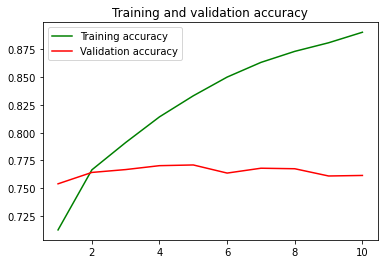

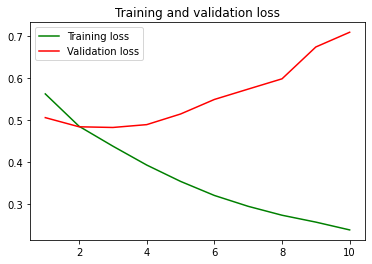

In [ ]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
new_model.save('model_word2vec_weights.h5')

In [ ]:
model=tf.keras.models.load_model('model_word2vec_weights.h5')

In [ ]:
y_pred = model.evaluate([test_q1,test_q2],test_labels, batch_size=1000, verbose=1)

134/134 [==============================] - 10s 69ms/step - loss: 0.7090 - accuracy: 0.7615
